## imports

In [1]:
from FC_2D_PINN_PlaneStress import *
import torch
import numpy as np
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Question 1: Solve the 2D plane stress problem of elasticity using PINN using PDE and BC losses. Use stochastic gradient descent for training.

- loading the training data

In [2]:
# load data points

# interior points
xy_f_train = scipy.io.loadmat('interior_points.mat')
x = xy_f_train['x'].flatten()[:,None]
y = xy_f_train['y'].flatten()[:,None]
xy_f_train = np.concatenate((x,y), axis=1)

# boundary points
xy_b_train = scipy.io.loadmat('boundary_points.mat')
x_b = xy_b_train['x_bdry'].flatten()[:,None]
y_b = xy_b_train['y_bdry'].flatten()[:,None]
xy_b_train = np.concatenate((x_b,y_b), axis=1)

- converting the data to tensors

In [3]:
xy_f_train = torch.tensor( xy_f_train, requires_grad=True, dtype=torch.float32).to(device)
xy_b_train = torch.tensor( xy_b_train, requires_grad=True, dtype=torch.float32).to(device)

# Define the boundary condition values
u_b_train =  torch.tensor( np.zeros((xy_b_train.shape[0],1)), requires_grad=True, dtype=torch.float32).to(device)
v_b_train = torch.tensor( np.zeros((xy_b_train.shape[0],1)), requires_grad=True, dtype=torch.float32).to(device)


- Constants values

In [4]:
# define some constants
E = 1                                       # Young's Modulus
nu = 0.3                                    # Poisson Ratio
G = E/(2*(1+nu))                            # Shear Modulus

In [5]:
pinnModel = Model(E, nu, G)

Sequential(
  (Linear_layer_1): Linear(in_features=2, out_features=30, bias=True)
  (Tanh_layer_1): Tanh()
  (Linear_layer_2): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_2): Tanh()
  (Linear_layer_3): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_3): Tanh()
  (Linear_layer_4): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_4): Tanh()
  (Linear_layer_5): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_5): Tanh()
  (Linear_layer_6): Linear(in_features=30, out_features=30, bias=True)
  (Tanh_layer_6): Tanh()
)


In [6]:
pde_losses, bc_losses = pinnModel.train(xy_f_train, xy_b_train, u_b_train, v_b_train, epochs=2000, learning_rate=0.0005)

epoch 0: total loss 1.26550055, loss_pde 1.25351810, loss_bc 0.01198239
epoch 100: total loss 0.58828402, loss_pde 0.49581259, loss_bc 0.09247144
epoch 200: total loss 0.14332813, loss_pde 0.12004431, loss_bc 0.02328382
epoch 300: total loss 0.03566074, loss_pde 0.03289793, loss_bc 0.00276281
epoch 400: total loss 0.01911098, loss_pde 0.01716156, loss_bc 0.00194941
epoch 500: total loss 0.01158263, loss_pde 0.00961599, loss_bc 0.00196664
epoch 600: total loss 0.00718126, loss_pde 0.00530050, loss_bc 0.00188075
epoch 700: total loss 0.00530955, loss_pde 0.00354274, loss_bc 0.00176681
epoch 800: total loss 0.00405415, loss_pde 0.00234578, loss_bc 0.00170838
epoch 900: total loss 0.00342423, loss_pde 0.00180773, loss_bc 0.00161650
epoch 1000: total loss 0.00298402, loss_pde 0.00148491, loss_bc 0.00149910
epoch 1100: total loss 0.00260572, loss_pde 0.00122942, loss_bc 0.00137630
epoch 1200: total loss 0.00234116, loss_pde 0.00107465, loss_bc 0.00126651
epoch 1300: total loss 0.00214935, lo

## 1. Plot the displacement field contours in 𝑥 − and 𝑦 − directions after training the model

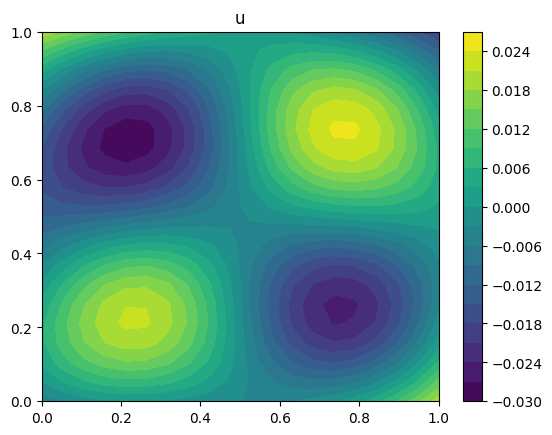

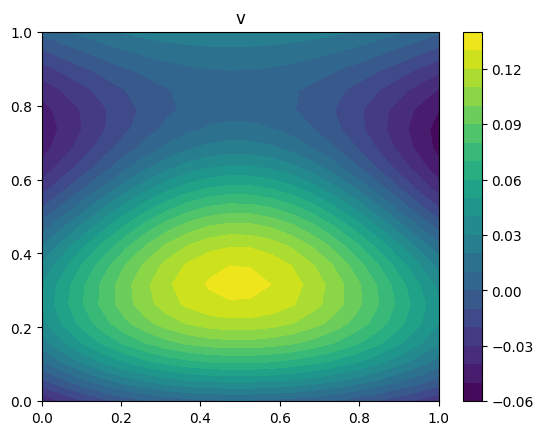

In [7]:
# Plot the displacement field contours
x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
X, Y = np.meshgrid(x,y)
xy = np.concatenate((X.flatten()[:,None],Y.flatten()[:,None]), axis=1)
xy = torch.tensor( xy, requires_grad=True, dtype=torch.float32).to(device)
predictions = pinnModel.Nnet(xy)
u_pred, v_pred = predictions[:,0], predictions[:,1]
U_pred = u_pred.cpu().detach().numpy()
V_pred = v_pred.cpu().detach().numpy()
U_pred = U_pred.reshape(X.shape)
V_pred = V_pred.reshape(X.shape)
plt.figure()
plt.contourf(X,Y,U_pred,20)
plt.colorbar()
plt.title('u')
plt.figure()
plt.contourf(X,Y,V_pred,20)
plt.colorbar()
plt.title('v');

## 2. Plot the total loss, PDE loss and BC loss versus epochs

In [8]:
# add the values of two losses
pde_losses = np.array(pde_losses)
bc_losses = np.array(bc_losses)
total_losses = pde_losses + bc_losses

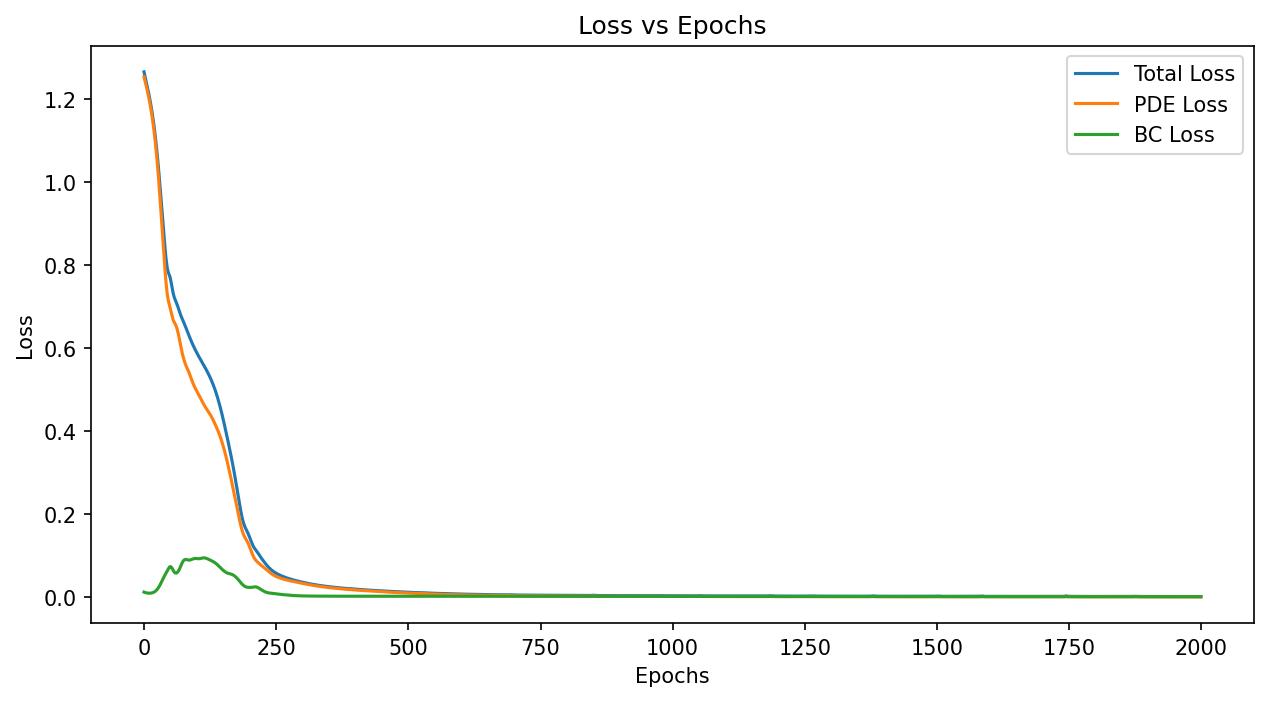

In [9]:
plt.figure( figsize=(10,5), dpi=150)
plt.plot(total_losses, label='Total Loss')
plt.plot(pde_losses, label='PDE Loss')
plt.plot(bc_losses, label='BC Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss');

## 3. Save the trained model (parameters) using `torch.save()`

In [33]:
# save the model
torch.save(pinnModel.Nnet, 'pinnModel.pt')

## 4. Generate random collocation points sampled from a uniform distribution in the interior (n = 2000 pairs) and boundary of the domain (n = 4*100 pairs). Concatenate all the sampled points and give as input to the trained model.

- Generate 2000 pair of interior points

In [55]:
# generate random collection of points sampled from a uniform distribution in interior (n= 2000 pairs)
epsilon = 1e-4
x = np.linspace(0+epsilon, 1-epsilon, 45)
y = np.linspace(0+epsilon, 1-epsilon, 45)
# create meshgrid
X, Y = np.meshgrid(x,y)
# concatenate the x and y coordinates
xy = np.concatenate((X.flatten()[:,None],Y.flatten()[:,None]), axis=1)

- Generate 400 pair of boundary points

In [56]:
# generate 400 points on the boundary
x_b = np.linspace(0,1,20)
y_b = np.linspace(0,1,20)
X_b, Y_b = np.meshgrid(x_b,y_b)
xy_b = np.concatenate((X_b.flatten()[:,None],Y_b.flatten()[:,None]), axis=1)

In [57]:
# concatenate the two sets of points
xy = np.concatenate((xy, xy_b), axis=0)
xy = torch.tensor( xy, requires_grad=True, dtype=torch.float32).to(device)

## 5. Load the saved model using `torch.load()`

In [58]:
# load the saved model using torch.load()
saved_model = torch.load('pinnModel.pt')

## 6. Test your trained model on the generated collocation points and plot the displacement field. 

In [60]:
# Plot the displacement field contours
predictions = saved_model.eval()(xy)
predictions_b = predictions[-400:]
predictions_f = predictions[:-400]


u_pred, v_pred = predictions_f[:,0], predictions_f[:,1]
U_pred = u_pred.cpu().detach().numpy()
V_pred = v_pred.cpu().detach().numpy()
U_pred = U_pred.reshape(X.shape)
V_pred = V_pred.reshape(X.shape)

u_pred_b, v_pred_b = predictions_b[:,0], predictions_b[:,1]
U_pred_b = u_pred_b.cpu().detach().numpy()
V_pred_b = v_pred_b.cpu().detach().numpy()
U_pred_b = U_pred_b.reshape(X_b.shape)
V_pred_b = V_pred_b.reshape(X_b.shape)



- Interior points plot

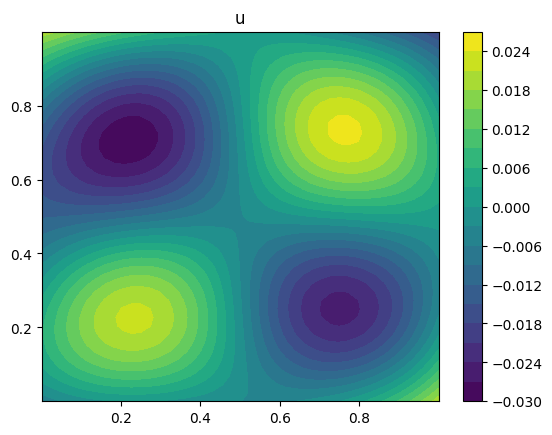

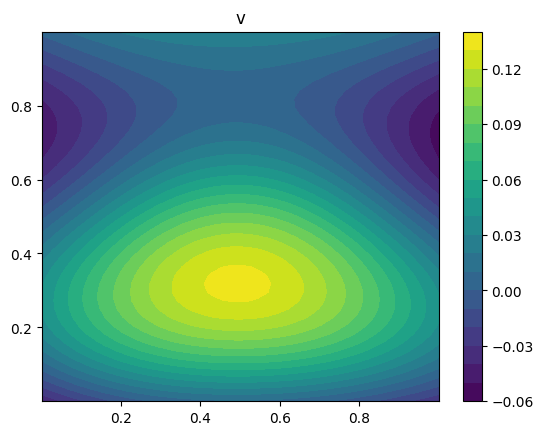

In [61]:
plt.figure()
plt.contourf(X,Y,U_pred,20)
plt.colorbar()
plt.title('u')
plt.figure()
plt.contourf(X,Y,V_pred,20)
plt.colorbar()
plt.title('v');

- Boundary points plot

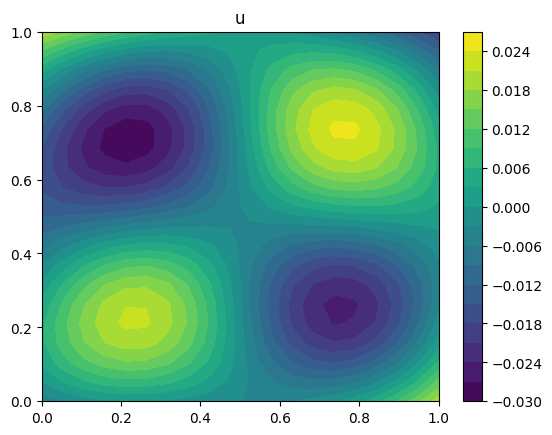

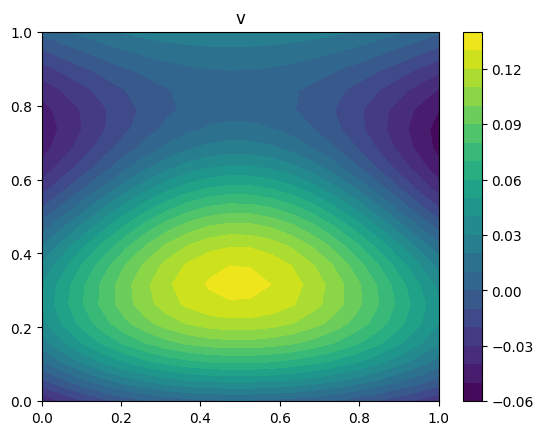

In [62]:
plt.figure()
plt.contourf(X_b,Y_b,U_pred_b,20)
plt.colorbar()
plt.title('u')
plt.figure()
plt.contourf(X_b,Y_b,V_pred_b,20)
plt.colorbar()
plt.title('v');